# OOI DAS Probabilistic PSD

In [190]:
import gc
import os
import h5py
import glob
import datetime
import numpy as np
import time as time
import pandas as pd
import scipy.signal as sgn

from tqdm import tqdm

import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['DejaVu Sans']
matplotlib.rcParams['font.size'] = 20

## Southern cable, 60 minutes

In [14]:
raw_dir = '/data/data2/south-data-ejm/hdd/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/'
files = glob.glob(raw_dir + 'South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-02T23[012]?14Z.h5')
len(files)

60

In [15]:
### Read 60 files and concatenate them
all_data = []
all_time = []
for i, file_name in tqdm(enumerate(files)):
    with h5py.File(file_name, 'r') as f:
        time_data = f['Acquisition']['Raw[0]']['RawData'][:]
        timestamps = f['Acquisition']['Raw[0]']['RawDataTime'][:]
        
        if i==0:
            sample_rate= f['Acquisition']['Raw[0]'].attrs['OutputDataRate']
            gauge_len = f['Acquisition'].attrs['GaugeLength']
            dchannel = f['Acquisition'].attrs['SpatialSamplingInterval']
    all_data.append(time_data)
    all_time.append(timestamps)
    
full_data = np.concatenate(all_data, axis=1)
full_time = np.concatenate(all_time, axis=0)
times=[datetime.datetime.utcfromtimestamp(time1/1e6) for time1 in full_time]

60it [16:25, 16.42s/it]


### 1. Visualize strain in several channels

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-25-531568d01746>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].loglog(1/freq,psd,label='%.1f km' % (chan*dchannel*1e-3))
<ipython-input-25-531568d01746>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].loglog(1/freq,psd,label='%.1f km' % (chan*dchannel*1e-3))
<ipython-input-25-531568d01746>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].loglog(1/freq,psd,label='%.1f km' % (chan*dchannel*1e-3))
<ipython-input-25-531568d01746>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].loglog(1/freq,psd,label='%.1f km' % (chan*dchannel*1e-3))
<ipython-input-25-531568d01746>:13: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].loglog(1/freq,psd,label='%.1f km' % (chan*dchannel*1e-3))
100%|██████████| 5/5 [00:00<00:00, 54.89it/s]


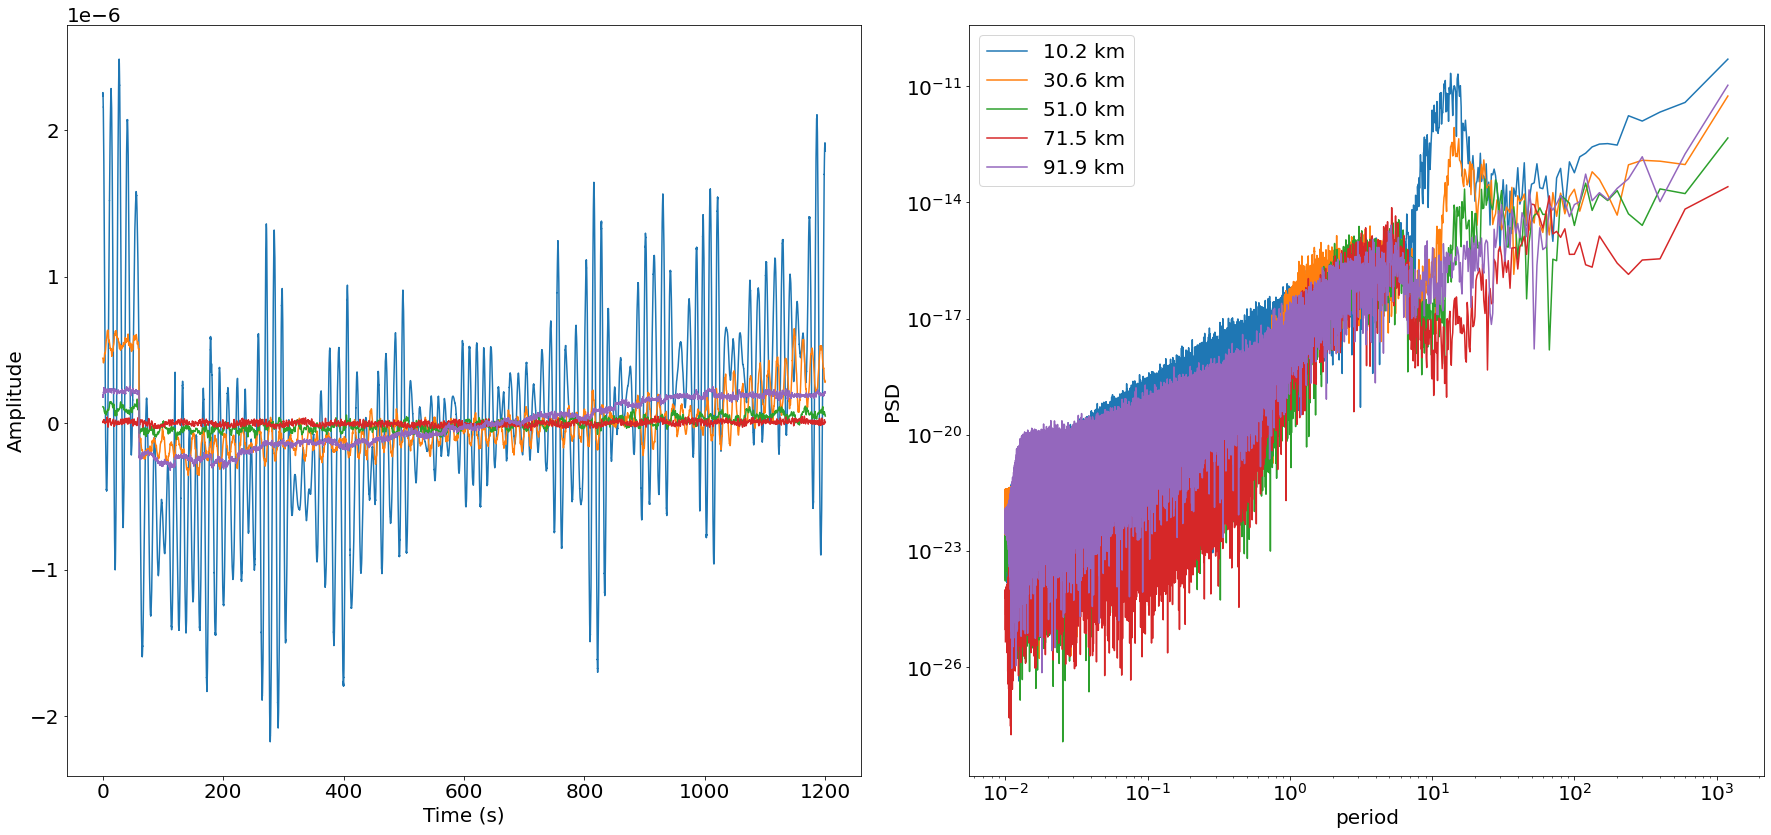

In [25]:
### No stacking
nx, ns = full_data.shape[0], full_data.shape[1]

fig,ax = plt.subplots(1,2,figsize=(25,12))

for chan in tqdm(np.arange(5000,nx,10000)):
    ### Correct raw data to strain
    tr = full_data[chan,:int(ns/3)].astype(float) * (1550 * 1e-9) / (0.78 * 2 * 1.4682 * gauge_len) / 2**16
    tr -= np.mean(tr) # remove the mean
    freq, psd = sgn.periodogram(tr, sample_rate, window='hamming')
#     freq, psd = sgn.welch(tr, sample_rate)
    ax[0].plot(np.arange(int(ns/3)) / sample_rate, tr)
    ax[1].loglog(1/(freq+1e-7),psd,label='%.1f km' % (chan*dchannel*1e-3))
    
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlabel('period')
ax[1].set_ylabel('PSD')
plt.legend()
plt.tight_layout()

### 2. Stacking 2000 neighboring channels

  0%|          | 0/5 [00:00<?, ?it/s]<ipython-input-88-bdea3a71a401>:17: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].loglog(1/freq0, psd_ave, label='%.1f km' % (chan*dchannel*1e-3))
 20%|██        | 1/5 [00:37<02:30, 37.52s/it]<ipython-input-88-bdea3a71a401>:17: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].loglog(1/freq0, psd_ave, label='%.1f km' % (chan*dchannel*1e-3))
 40%|████      | 2/5 [01:15<01:53, 37.68s/it]<ipython-input-88-bdea3a71a401>:17: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].loglog(1/freq0, psd_ave, label='%.1f km' % (chan*dchannel*1e-3))
 60%|██████    | 3/5 [01:54<01:16, 38.21s/it]<ipython-input-88-bdea3a71a401>:17: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].loglog(1/freq0, psd_ave, label='%.1f km' % (chan*dchannel*1e-3))
 80%|████████  | 4/5 [02:31<00:37, 37.89s/it]<ipython-input-88-bdea3a71a401>:17: RuntimeWarning: divide by zero encountered in true_divide
  ax[1].loglog(1/freq

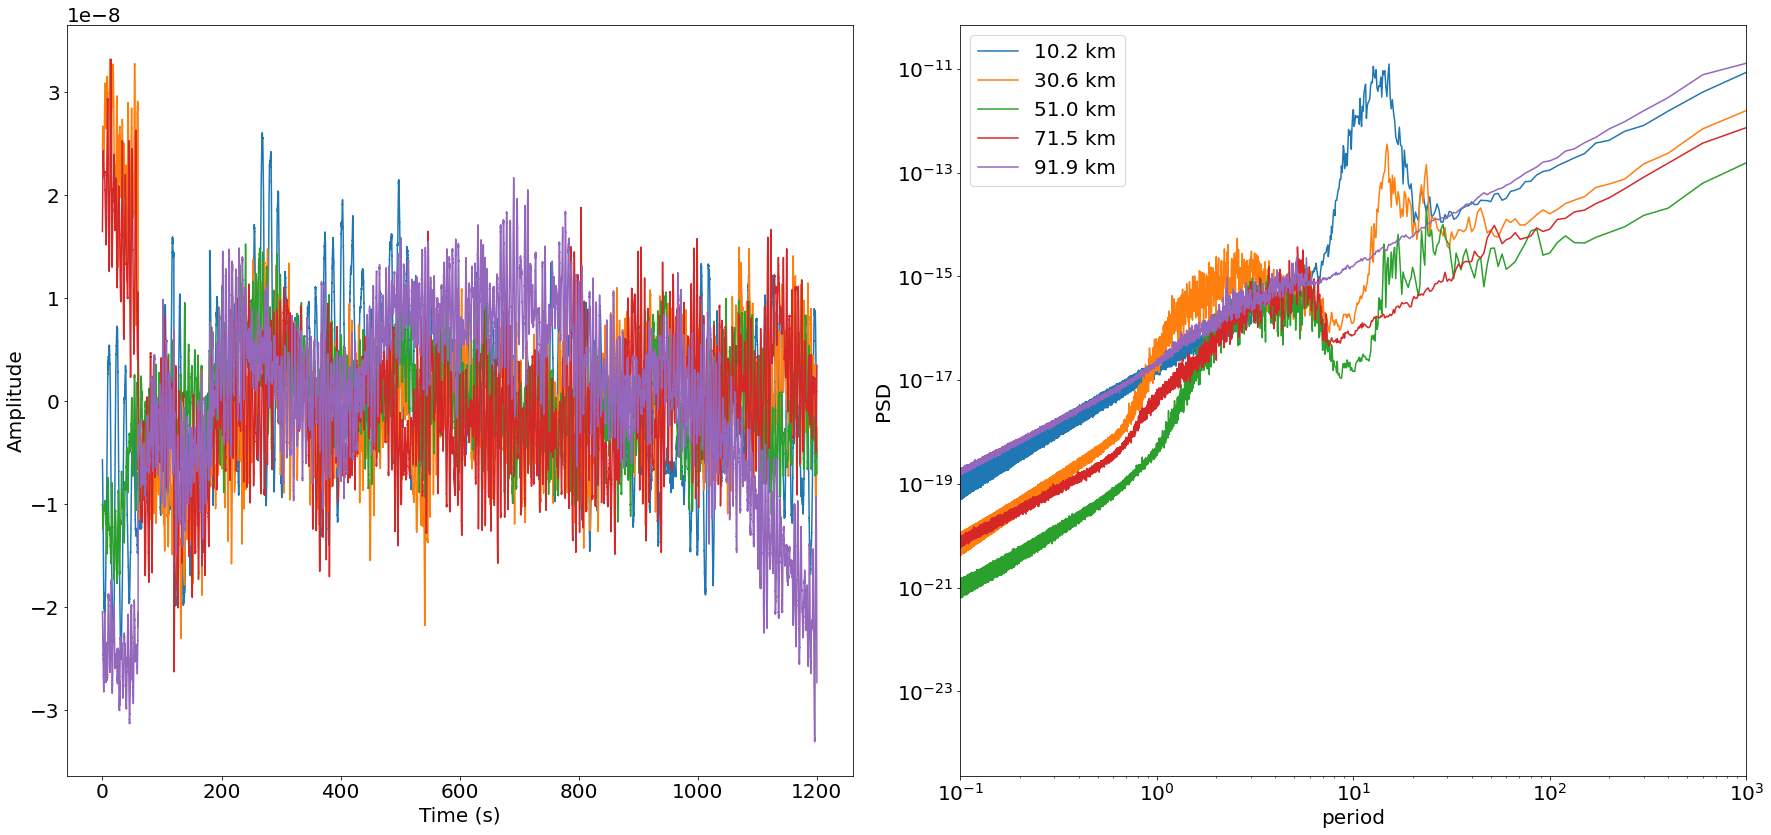

In [88]:
fig,ax = plt.subplots(1,2,figsize=(25,12))

for chan in tqdm(np.arange(5000,nx,10000)):
    
    ### Correct raw data to strain
    trs = full_data[chan:chan+2000,:int(ns/3)].astype(float) * (1550 * 1e-9) / (0.78 * 2 * 1.4682 * gauge_len) / 2**16
    trs -= np.mean(trs, axis=1, keepdims=True) # remove the mean
    trs = sgn.detrend(trs, axis=-1)
    freq =[]
    psd = []

    freq0, psd0 = sgn.periodogram(trs[:,:], sample_rate, window='hamming')
    psd_ave = np.mean(np.array(psd0), axis=0)
    
    ax[0].plot(np.arange(int(ns/3)) / sample_rate, np.mean(trs, axis=0))
    ax[1].loglog(1/(freq0+1e-7), psd_ave, label='%.1f km' % (chan*dchannel*1e-3))
    
ax[1].set_xlim(1e-1,1e3)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlabel('period')
ax[1].set_ylabel('PSD')
plt.legend()
plt.tight_layout()

### 3. Probabilistic PSD of one segment (continuous 2000 channels)

In [197]:
### functions to calculate PDF of multiple channels
### Modified from Enthan Williams's code
def ppsd(data,fs,fmin,fmax):
    """
    data:  2D array, the statistics is calculated along axis=0
    fs: sampling rate
    fmin: minimum frequency for statistics
    fmax: maximum frequency for statictics
    """
    ns = data.shape[1]
    nx = data.shape[0]
    
    ### Demean, detrend
    data -= np.mean(data, axis=1, keepdims=True) 
    data = sgn.detrend(data, axis=1) 
    
    freq, spec = sgn.periodogram(data, sample_rate, window='hamming', axis=-1)
    freq = np.tile(freq,(nx,1)).flatten()

    ### Generate PDF
    xbins = np.logspace(np.log10(fmin),np.log10(fmax),60)
    ybins = np.logspace(np.log10(np.nanmin(spec)),np.log10(np.nanmax(spec)),100)
    
    H,xe,ye = np.histogram2d(freq.flatten(), spec.flatten(), bins=(xbins,ybins))
    
    return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2
    
def psd_stats(H,xm,ym):   
    ym = np.log10(ym)
    mean = np.zeros(len(xm))
    variance = mean.copy()
    for ix in range(len(xm)):
        mean[ix] = np.average(ym,weights=H[ix,:])
        variance[ix] = np.average((ym-mean[ix])**2,weights=H[ix,:])
    
    return xm,10**mean,variance

<ipython-input-157-8775e4c491ed>:24: RuntimeWarning: invalid value encountered in true_divide
  return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2


Text(0, 0.5, 'dB rel. strain')

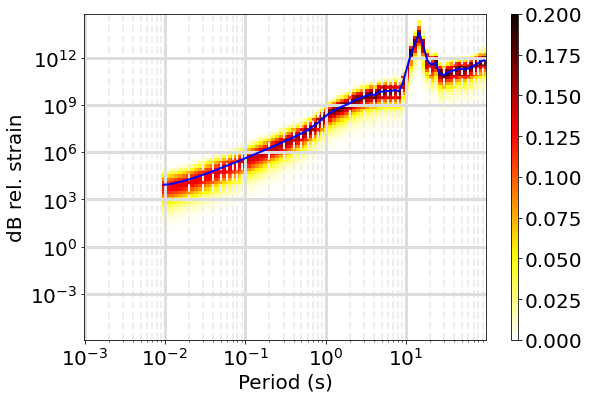

In [179]:
### plot PPSD for one segment
sample = full_data[10000:12000,:int(ns/3)].astype(float)
H,xm,ym = ppsd(sample,sample_rate,1e-2,1e3)
xm,mn,vr = psd_stats(H,xm,ym)

plt.figure(figsize=(9,6))
plt.pcolormesh(1/xm,ym,H.T,cmap='hot_r',vmin=0,vmax=0.2, zorder=1)
plt.plot(1/xm,mn,'b',linewidth=2, zorder=2)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.colorbar(aspect=50)
plt.grid(which='major', color='#DDDDDD', linewidth=3, zorder=0)
plt.grid(which='minor', color='#EEEEEE', linewidth=2, linestyle='--', zorder=0)
plt.xlabel('Period (s)')
plt.ylabel('dB rel. strain')

### 4. PPSD mean values for all segments

0it [00:00, ?it/s]<ipython-input-197-a8cd866c4405>:25: RuntimeWarning: invalid value encountered in true_divide
  return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2
1it [00:55, 55.26s/it]<ipython-input-197-a8cd866c4405>:25: RuntimeWarning: invalid value encountered in true_divide
  return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2
2it [01:46, 53.04s/it]<ipython-input-197-a8cd866c4405>:25: RuntimeWarning: invalid value encountered in true_divide
  return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2
3it [02:38, 52.54s/it]<ipython-input-197-a8cd866c4405>:25: RuntimeWarning: invalid value encountered in true_divide
  return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2
4it [03:30, 52.34s/it]<ipython-input-197-a8cd866c4405>:25: RuntimeWarning: invalid value encountered in true_divide
  return H/np.nansum(H, axis=1, keepdims=True), (xe[1:] + xe

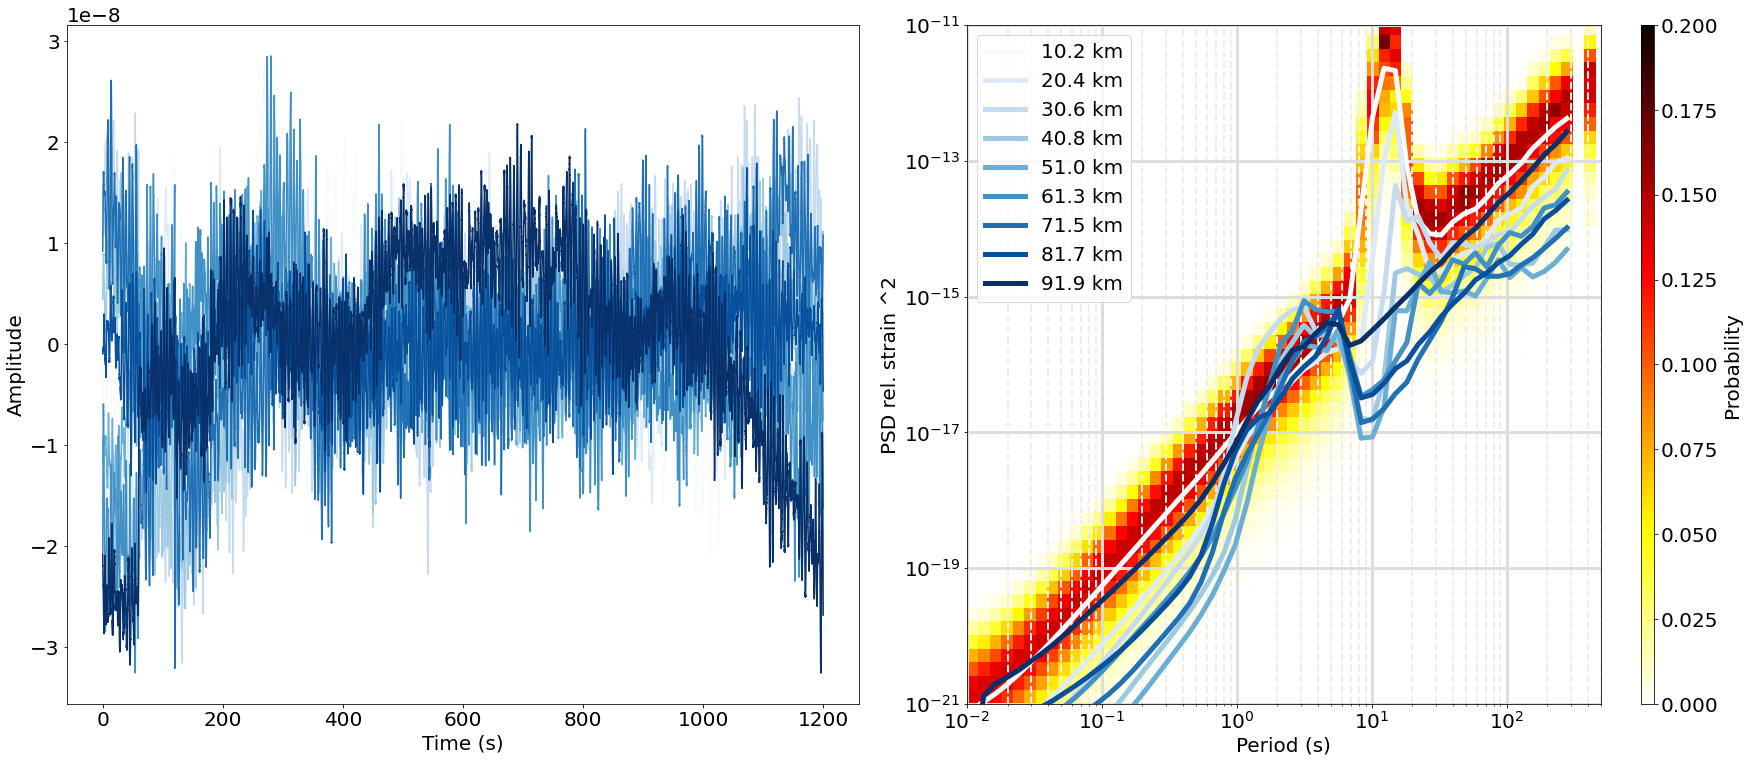

In [198]:
fig,ax = plt.subplots(1,2,figsize=(25,11))
colors = matplotlib.colormaps['Blues'](np.linspace(0, 1, 9))

for i, chan in tqdm(enumerate(np.arange(5000,nx,5000))):
    
    ### Correct raw data to strain
    trs = full_data[chan:chan+2000,:int(ns/3)].astype(float) * (1550 * 1e-9) / (0.78 * 2 * 1.4682 * gauge_len) / 2**16
    
    H,xm,ym = ppsd(trs,sample_rate,1e-3,1e2)
    xm,mn,vr = psd_stats(H,xm,ym)

    
    ax[0].plot(np.arange(int(ns/3)) / sample_rate, np.mean(trs, axis=0), color=colors[i])
    ax[1].plot(1/xm, mn,linewidth=5, label='%.1f km' % (chan*dchannel*1e-3), zorder=2, color=colors[i])
    if chan <= 5000:
        img=ax[1].pcolormesh(1/xm,ym,H.T,cmap='hot_r',vmin=0,vmax=0.2, zorder=1)
        

ax[1].set_xscale('log')
ax[1].set_yscale('log')   
ax[1].set_xlim(1e-2,5e2)
ax[1].set_ylim(1e-21,1e-11)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[1].set_xlabel('Period (s)')
ax[1].set_ylabel('PSD rel. strain ^2')
ax[1].grid(which='major', color='#DDDDDD', linewidth=3, zorder=0)
ax[1].grid(which='minor', color='#EEEEEE', linewidth=2, linestyle='--', zorder=0)
plt.colorbar(img, ax=ax[1], aspect=50).set_label('Probability')
plt.legend()
plt.tight_layout()